# Train and Evaluating Classifiers

We will go try different classifiers and tune them


### Imports

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
from utils import random_search_cv, plot_search_results
from spaceship_preprocessing.pipeline import SpaceshipPreprocessor


## Data Loading 

In [3]:

# Initialize the preprocessor with desired settings
preprocessor = SpaceshipPreprocessor(
    handle_unknown_categories='ignore',
    n_cabin_groups=5,
    add_location_features=True
)

# Get preprocessed training and test data
X, X_test, y = preprocessor.preprocess_data(
    train_data_path='data/train.csv',
    test_data_path='data/test.csv'
)

# Print information about the transformed data
print("\nProcessed Data Info:")
print("-------------------")
print("Training set shape:", X.shape)
print("Test set shape:", X_test.shape)
print("Target variable shape:", y.shape)

# Get and print feature names
feature_names = preprocessor.get_feature_names()
print("\nFeatures:", feature_names)


Processed Data Info:
-------------------
Training set shape: (8693, 48)
Test set shape: (4277, 49)
Target variable shape: (8693,)

Features: ['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'FirstNameInitial', 'LastNameInitial', 'HomePlanet_Missing', 'Destination_Missing', 'CryoSleep_Missing', 'VIP_Missing', 'Cabin_Number_Group', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_Unknown', 'Cabin_Side_P', 'Cabin_Front', 'Cabin_Back', 'HP_Earth', 'HP_Europa', 'HP_Mars', 'Dest_55 Cancri e', 'Dest_PSO J318.5-22', 'Dest_TRAPPIST-1e', 'TotalSpending', 'RoomService_Ratio', 'FoodCourt_Ratio', 'ShoppingMall_Ratio', 'Spa_Ratio', 'VRDeck_Ratio', 'RoomService_Log', 'FoodCourt_Log', 'ShoppingMall_Log', 'Spa_Log', 'VRDeck_Log', 'TotalSpending_Log', 'GroupSize', 'IsSolo', 'AgeGroup']


/Users/julienh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/julienh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
# split into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X[['TotalSpending']].head()

TotalSpending
0      -1.431339
1      -0.692277
2       6.884246
3       3.121114
4      -0.172431

In [19]:
X.head()

CryoSleep       Age  VIP  RoomService  FoodCourt  ShoppingMall       Spa  \
0          0  0.711945    0    -0.333105  -0.281027     -0.283579 -0.270626   
1          0 -0.334037    0    -0.168073  -0.275387     -0.241771  0.217158   
2          0  2.036857    1    -0.268001   1.959998     -0.283579  5.695623   
3          0  0.293552    0    -0.333105   0.523010      0.336851  2.687176   
4          0 -0.891895    0     0.125652  -0.237159     -0.031059  0.231374   

     VRDeck  FirstNameInitial  LastNameInitial  ...  VRDeck_Ratio  \
0 -0.263003                12               14  ...      0.183746   
1 -0.224205                 9               21  ...      0.323865   
2 -0.219796                 0               18  ...     -0.031927   
3 -0.092818                18               18  ...     -0.029739   
4 -0.261240                22               18  ...      1.515037   

   RoomService_Log  FoodCourt_Log  ShoppingMall_Log   Spa_Log  VRDeck_Log  \
0        -0.405122      -0.329931         -0.333487 -0.315569   -0.305172   
1        -0.184011      -0.322117         -0.276769  0.196519   -0.253867   
2        -0.311976       1.085188         -0.333487  1.901454   -0.248200   
3        -0.405122       0.420688          0.290317  1.304861   -0.097413   
4         0.118362      -0.270705         -0.031551  0.208131   -0.302782   

   TotalSpending_Log  GroupSize  IsSolo  AgeGroup  
0           0.071594          1       1         0  
1          -1.178556          1       1         1  
2           2.064867          2       0         0  
3           1.416123          2       0         0  
4          -0.189263          1       1         1  

[5 rows x 48 columns]

In [6]:
X.isna().sum()

CryoSleep              0
Age                    0
VIP                    0
RoomService            0
FoodCourt              0
ShoppingMall           0
Spa                    0
VRDeck                 0
FirstNameInitial       0
LastNameInitial        0
HomePlanet_Missing     0
Destination_Missing    0
CryoSleep_Missing      0
VIP_Missing            0
Cabin_Number_Group     0
Deck_A                 0
Deck_B                 0
Deck_C                 0
Deck_D                 0
Deck_E                 0
Deck_F                 0
Deck_G                 0
Deck_T                 0
Deck_Unknown           0
Cabin_Side_P           0
Cabin_Front            0
Cabin_Back             0
HP_Earth               0
HP_Europa              0
HP_Mars                0
Dest_55 Cancri e       0
Dest_PSO J318.5-22     0
Dest_TRAPPIST-1e       0
TotalSpending          0
RoomService_Ratio      0
FoodCourt_Ratio        0
ShoppingMall_Ratio     0
Spa_Ratio              0
VRDeck_Ratio           0
RoomService_Log        0


## Unsupervised Learning Methods

Lets see if we can use dimensionaity reduction techniques to reduce the dimensionality of our data.

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_test_pca = pca.transform(X_test.drop(columns=['PassengerId']))

# graph it
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Training Data')
plt.show()


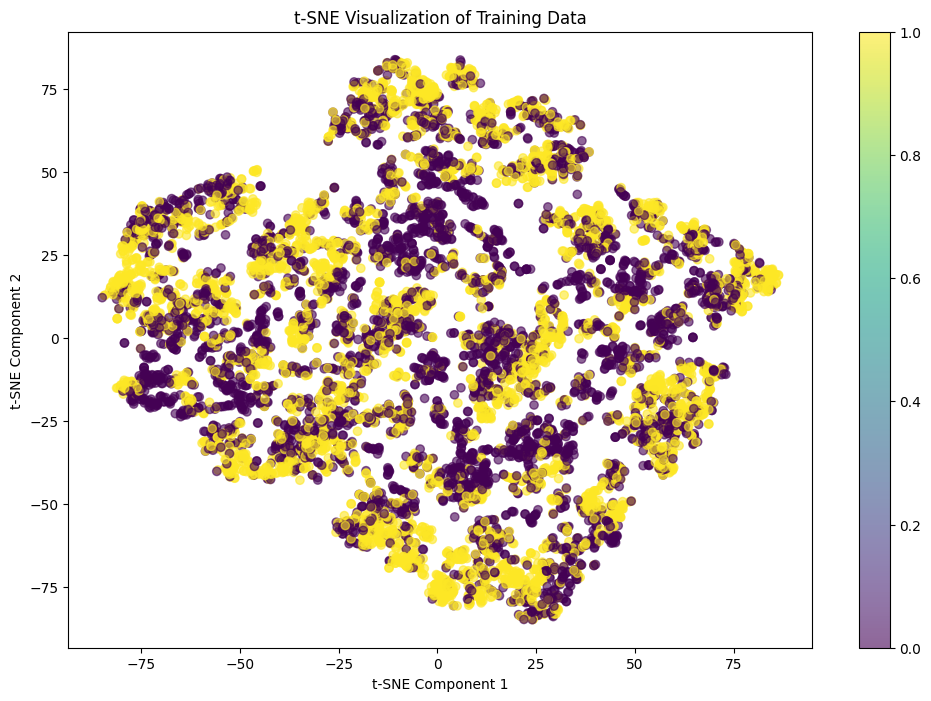

In [10]:
from sklearn.manifold import TSNE

# Initialize and fit TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)
X_test_tsne = tsne.fit_transform(X_test.drop(columns=['PassengerId']))

# Plot the TSNE results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2') 
plt.title('t-SNE Visualization of Training Data')
plt.show()


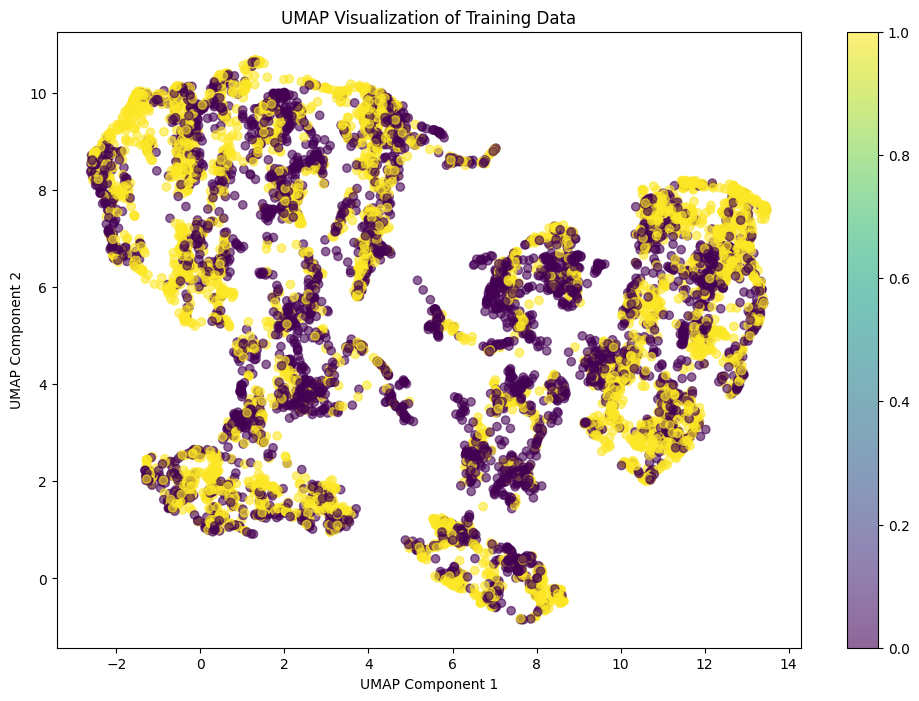

In [11]:
from umap import UMAP

# Initialize and fit UMAP
umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X)
X_test_umap = umap.transform(X_test.drop(columns=['PassengerId']))

# Plot the UMAP results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Visualization of Training Data')
plt.show()


## Training Classifiers

We want to select the best model for each ML model for ensemble later

### Random Forest Classifiers

A powerful tree ensemble that takes bootstraps (sample with replacement) of the data and train a decision tree on each bootstrap

In [20]:
# Random Forest parameters
rf_param_grid = {
    'n_estimators': list(randint(100, 500).rvs(10)),
    'max_depth': [None] + list(range(10, 50, 5)),
    'min_samples_split': list(randint(2, 20).rvs(10)),
    'min_samples_leaf': list(randint(1, 10).rvs(10)),
    'max_features': ['sqrt', 'log2', None]
}

# perform random search on the param grid
rf_results = random_search_cv(
    RandomForestClassifier(),
    X,
    y,
    rf_param_grid
)
 

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters found:
{'n_estimators': 136, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40}

Best cross-validation accuracy: 0.7978


In [23]:
plot_search_results(rf_results['cv_results'])


In [25]:
# saving the best model
best_rf_model = rf_results['best_model']

best_rf_model

RandomForestClassifier(max_depth=40, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=136)

#### Feauture Importance Extraction 

We will ues the best rf model we found to extract the feature importance.

We will run 100 iterations of the model and extract the feature importance.

In [26]:

# Perform multiple trainings with different random seeds
n_iterations = 100
importance_scores = []
accuracies = []

for i in range(n_iterations):
    # Create and train Random Forest with different random state
    best_rf_model.fit(X_train, y_train)
    
    # Store feature importances
    importance_scores.append(best_rf_model.feature_importances_)
    
    # Calculate and store accuracy
    y_pred = best_rf_model.predict(X_val)
    accuracy = np.mean(y_pred == y_val)
    accuracies.append(accuracy)
    #print(f"Iteration {i+1} Accuracy: {accuracy:.4f}")

# Convert to numpy array for easier manipulation
importance_scores = np.array(importance_scores)

# Calculate mean and std of importances
mean_importances = np.mean(importance_scores, axis=0)
std_importances = np.std(importance_scores, axis=0)

# Sort features by mean importance
indices = np.argsort(mean_importances)[::-1]
sorted_features = X_train.columns[indices]

# Plot
plt.figure(figsize=(12, 8))
y_pos = np.arange(len(sorted_features))

plt.barh(y_pos, mean_importances[indices], xerr=std_importances[indices],
         align='center', alpha=0.8, capsize=5, color='skyblue', ecolor='gray')

plt.yticks(y_pos, sorted_features)
plt.xlabel('Mean Feature Importance ± Standard Deviation')
plt.ylabel('Features')
plt.title(f'Feature Importance (averaged over {n_iterations} runs)\nMean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')
plt.tight_layout()
plt.show()

# Print numerical results
print("\nFeature Importance Summary:")
for idx in indices:
    print(f"{X_train.columns[idx]}: {mean_importances[idx]:.4f} ± {std_importances[idx]:.4f}")


Feature Importance Summary:
TotalSpending: 0.0896 ± 0.0106
CryoSleep: 0.0617 ± 0.0094
Spa: 0.0480 ± 0.0048
FoodCourt_Ratio: 0.0471 ± 0.0037
Spa_Log: 0.0470 ± 0.0044
RoomService_Ratio: 0.0458 ± 0.0046
RoomService_Log: 0.0417 ± 0.0038
RoomService: 0.0407 ± 0.0037
VRDeck: 0.0386 ± 0.0044
VRDeck_Log: 0.0385 ± 0.0035
Spa_Ratio: 0.0385 ± 0.0038
FoodCourt_Log: 0.0359 ± 0.0022
VRDeck_Ratio: 0.0358 ± 0.0035
FoodCourt: 0.0358 ± 0.0020
ShoppingMall_Ratio: 0.0327 ± 0.0034
TotalSpending_Log: 0.0310 ± 0.0031
Age: 0.0304 ± 0.0008
ShoppingMall_Log: 0.0269 ± 0.0019
ShoppingMall: 0.0268 ± 0.0018
FirstNameInitial: 0.0225 ± 0.0006
HP_Earth: 0.0218 ± 0.0019
LastNameInitial: 0.0211 ± 0.0005
Cabin_Number_Group: 0.0175 ± 0.0005
HP_Europa: 0.0148 ± 0.0015
Deck_G: 0.0143 ± 0.0014
Cabin_Side_P: 0.0141 ± 0.0004
Deck_F: 0.0110 ± 0.0008
Deck_E: 0.0105 ± 0.0006
GroupSize: 0.0100 ± 0.0003
Cabin_Back: 0.0066 ± 0.0003
HP_Mars: 0.0062 ± 0.0006
Dest_TRAPPIST-1e: 0.0052 ± 0.0003
Dest_55 Cancri e: 0.0051 ± 0.0003
Deck_C: 

### Gradient Boosting Classifiers

A popular ensemble technique that builds trees one at a time, each tree corrects the errors of the previous one

In [29]:

# Gradient Boosting parameters
gb_param_grid = {
    'n_estimators': list(randint(100, 500).rvs(10)),
    'learning_rate': list(uniform(0.01, 0.3).rvs(10)),
    'max_depth': list(randint(3, 10).rvs(10)),
    'min_samples_split': list(randint(2, 20).rvs(10)),
    'min_samples_leaf': list(randint(1, 10).rvs(10)),
    'subsample': list(uniform(0.6, 0.4).rvs(10))
}

gb_results = random_search_cv(
    GradientBoostingClassifier(),
    X,
    y,
    gb_param_grid
)


Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters found:
{'subsample': 0.6086679506834994, 'n_estimators': 219, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_depth': 4, 'learning_rate': 0.040202887152510636}

Best cross-validation accuracy: 0.8038


In [30]:
plot_search_results(gb_results['cv_results'])


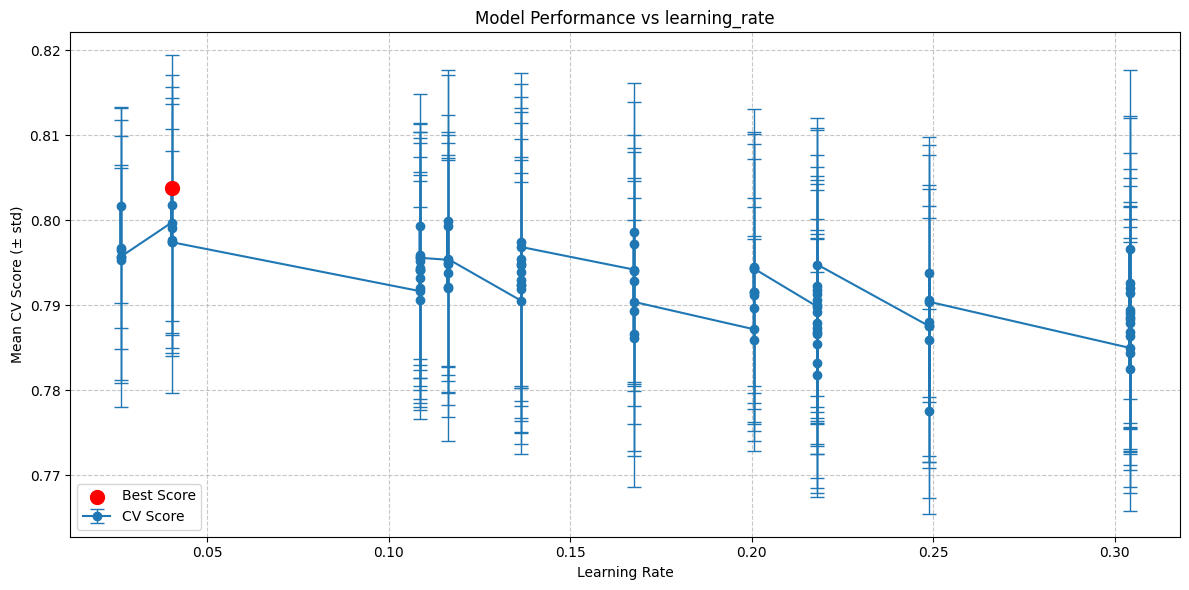

In [31]:
plot_search_results(gb_results['cv_results'], 'learning_rate')

In [32]:
# saving the best model
best_gb_model = gb_results['best_model']

best_gb_model

GradientBoostingClassifier(learning_rate=0.040202887152510636, max_depth=4,
                           min_samples_leaf=2, min_samples_split=12,
                           n_estimators=219, subsample=0.6086679506834994)

### Multi-layer Perceptron classifier

A multi-layer perceptron is a feedforward artificial neural network model that is trained using backpropagation. It is a non-linear model that can be used for classification and regression tasks.

In [16]:

# Neural Network parameters
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate_init': uniform(0.001, 0.01),
    'max_iter': [750, 1000]
}

mlp_results = random_search_cv(
    MLPClassifier(),
    X,
    y,
    mlp_param_grid
)


Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters found:
{'activation': 'relu', 'alpha': 0.0038228276656174305, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.007635017691080558, 'max_iter': 750}

Best cross-validation accuracy: 0.7828


In [33]:
plot_search_results(mlp_results['cv_results'])

NameError: name 'mlp_results' is not defined

In [21]:
best_mlp_model = mlp_results['best_model']

best_mlp_model


MLPClassifier(alpha=0.0038228276656174305, hidden_layer_sizes=(50,),
              learning_rate_init=0.007635017691080558, max_iter=750)

### Support Vector Classifiers

A supervised learning algorithm that finds the optimal hyperplane to separate data points from different classes by maximizing the margin between them. It works well for both linear and non-linear classification tasks, with non-linear capabilities achieved using kernel functions like RBF or polynomial kernels.

In [29]:
# Create a Support Vector Machine classifier
svc_model = SVC(kernel='rbf', random_state=42)

# Train the model
svc_model.fit(X_train, y_train)

# Make predictions
y_pred = svc_model.predict(X_val)

# Calculate accuracy
accuracy = np.mean(y_pred == y_val)
print("Accuracy:", accuracy)

Accuracy: 0.7705577918343876


### XGBoostClasifier

In [35]:
xgb_model = XGBClassifier(enable_categorical=True)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_val)
accuracy = np.mean(y_pred == y_val)
print("Accuracy:", accuracy)

Accuracy: 0.7947096032202415


## Training Ensemble Model

We will use a stacking classifier


In [5]:
if not 'best_rf_model' in locals():
    best_rf_model = RandomForestClassifier(max_depth=45, min_samples_leaf=2, min_samples_split=11,
                           n_estimators=198)

if not 'best_gb_model' in locals():
    best_gb_model = GradientBoostingClassifier(learning_rate=0.040202887152510636, max_depth=4,
                           min_samples_leaf=2, min_samples_split=12,
                           n_estimators=219, subsample=0.6086679506834994)

if not 'best_mlp_model' in locals():
    best_mlp_model = MLPClassifier(alpha=0.008121969807540395, hidden_layer_sizes=(50,),
                  learning_rate_init=0.0011563640674119393, max_iter=300)


In [36]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

class StackingClassifierModel:
    def __init__(self, base_estimators, final_estimator):
        self.base_estimators = base_estimators
        self.final_estimator = final_estimator

    def fit(self, X, y):
        self.stacking_clf = StackingClassifier(estimators=self.base_estimators, final_estimator=self.final_estimator)
        self.stacking_clf.fit(X, y)

    def predict(self, X):
        return self.stacking_clf.predict(X)


# Create a Stacking classifier
stacking_model = StackingClassifierModel(base_estimators=[('rf', best_rf_model), ('gb', best_gb_model), ('xgb', xgb_model)], 
                                        final_estimator=GradientBoostingClassifier())

# Train the model
stacking_model.fit(X_train, y_train)

# Make predictions
y_pred = stacking_model.predict(X_val)

# Calculate accuracy
accuracy = np.mean(y_pred == y_val)
print("Accuracy:", accuracy)


Accuracy: 0.8016101207590569


In [ ]:
from sklearn.metrics import accuracy_score
import random

# Parameters for random search
n_iterations = 30 # Number of different combinations to try

# Define possible base estimators and final estimators
possible_base_estimators = {
    'rf': best_rf_model,
    'gb': best_gb_model,
    'xgb': xgb_model,
    'mlp': best_mlp_model,
    'svc': svc_model
}

possible_final_estimators = [
    LogisticRegression(),
    GradientBoostingClassifier(),
    RandomForestClassifier()
]

# Store results
ensemble_combinations = []
accuracies = []

for i in range(n_iterations):
    # Randomly select number of base estimators (at least 2)
    n_estimators = random.randint(2, len(possible_base_estimators))
    
    # Randomly select base estimators
    selected_estimators = random.sample(list(possible_base_estimators.items()), n_estimators)
    
    # Randomly select final estimator
    final_estimator = random.choice(possible_final_estimators)
    
    # Create and train stacking model
    stacking_model = StackingClassifierModel(
        base_estimators=selected_estimators,
        final_estimator=final_estimator
    )
    
    try:
        # Train and evaluate
        stacking_model.fit(X_train, y_train)
        y_pred = stacking_model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        
        # Store results
        ensemble_combinations.append({
            'base_estimators': [est[0] for est in selected_estimators],
            'final_estimator': type(final_estimator).__name__,
            'accuracy': acc
        })
        accuracies.append(acc)
        
        print(f"Iteration {i+1}: Accuracy = {acc:.4f}")
        
    except Exception as e:
        print(f"Error in iteration {i+1}: {str(e)}")
        continue

# Find best combination
best_idx = np.argmax(accuracies)
best_combo = ensemble_combinations[best_idx]

print(f"\nBest accuracy: {best_combo['accuracy']:.4f}")
print("\nBest combination:")
print(f"Base estimators: {best_combo['base_estimators']}")
print(f"Final estimator: {best_combo['final_estimator']}")

# Plot accuracy distribution
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=20, edgecolor='black')
plt.title('Distribution of Accuracies Across Ensemble Combinations')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.axvline(best_combo['accuracy'], color='red', linestyle='dashed', 
            label=f'Best Accuracy: {best_combo["accuracy"]:.4f}')
plt.legend()
plt.show()

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
import numpy as np

class RecursiveFeatureEnsemble:
    def __init__(self, base_models, final_estimator, n_features_to_select=10):
        self.base_models = base_models
        self.final_estimator = final_estimator
        self.n_features_to_select = n_features_to_select
        self.results = []
        
    def fit_and_evaluate(self, X_train, X_val, y_train, y_val, features):
        # Create and train stacking model with selected features
        stacking_model = StackingClassifierModel(
            base_estimators=self.base_models,
            final_estimator=self.final_estimator
        )
        
        # Train and evaluate using selected features
        stacking_model.fit(X_train[features], y_train)
        y_pred = stacking_model.predict(X_val[features])
        acc = accuracy_score(y_val, y_pred)
        
        return acc, stacking_model
    
    def fit(self, X_train, X_val, y_train, y_val):
        current_features = list(X_train.columns)
        
        while len(current_features) > self.n_features_to_select:
            feature_scores = {}
            
            # Try removing each feature one at a time
            for feature_to_remove in current_features:
                test_features = [f for f in current_features if f != feature_to_remove]
                acc, _ = self.fit_and_evaluate(X_train, X_val, y_train, y_val, test_features)
                feature_scores[feature_to_remove] = acc
            
            # Find feature whose removal gives best accuracy
            best_acc = max(feature_scores.values())
            worst_feature = max(feature_scores.items(), key=lambda x: x[1])[0]
            
            # Remove the worst feature
            current_features.remove(worst_feature)
            
            # Store results
            self.results.append({
                'n_features': len(current_features),
                'features': current_features.copy(),
                'accuracy': best_acc,
                'removed_feature': worst_feature
            })
            
            print(f"Features: {len(current_features)}, Accuracy: {best_acc:.4f}, Removed: {worst_feature}")
        
        # Find best feature set
        self.best_result = max(self.results, key=lambda x: x['accuracy'])
        
        # Train final model with best features
        self.best_accuracy, self.best_model = self.fit_and_evaluate(
            X_train, X_val, y_train, y_val, self.best_result['features']
        )
        
        return self

# Initialize and run recursive feature elimination
rfe_ensemble = RecursiveFeatureEnsemble(
    base_models=base_models,
    final_estimator=GradientBoostingClassifier(),
    n_features_to_select=10
)

# Fit the model
rfe_ensemble.fit(X_train, X_val, y_train, y_val)

# Plot results
plt.figure(figsize=(12, 6))

# Accuracy vs number of features
plt.plot([r['n_features'] for r in rfe_ensemble.results],
         [r['accuracy'] for r in rfe_ensemble.results],
         '-o')
plt.scatter(rfe_ensemble.best_result['n_features'], 
           rfe_ensemble.best_result['accuracy'],
           color='red', s=100, label='Best Result')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features during RFE')
plt.legend()
plt.grid(True)
plt.show()

# Print best results
print(f"\nBest accuracy: {rfe_ensemble.best_result['accuracy']:.4f}")
print(f"Number of features: {rfe_ensemble.best_result['n_features']}")
print("\nBest feature combination:")
for feature in sorted(rfe_ensemble.best_result['features']):
    print(f"- {feature}")

## Predicting on the test.csv data and then submitting the results to Kaggle

In [58]:
def create_submission(estimator, X_test, submission_name):
    """
    Create submission predictions and write to file
    
    Args:
        estimator: Trained model estimator
        X_test: Test data features
        submission_name: Name for the submission file
    """
    # Generate predictions
    passenger_ids = X_test['PassengerId']
    X_test = X_test.drop(columns=['PassengerId'])
    submission_predictions = estimator.predict(X_test)

    # Create submission dataframe
    submission_predictions = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Transported': submission_predictions
    })

    # Convert predictions to boolean
    submission_predictions['Transported'] = submission_predictions['Transported'].astype(bool)

    # Save submission file
    submission_predictions.to_csv(f'submissions/{submission_name}_submission.csv', index=False)
    
    return submission_predictions

# Create submission using stacking model
create_submission(stacking_model, X_test, "stacking_gb_meta")


PassengerId  Transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]